In [1]:
#Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
mypal = plt.rcParams['axes.prop_cycle'].by_key()['color'] # Grab the color pal
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('data/train.csv')
df

,Weekend,Month,Top Referee,Outcome,Home Avg Goal,Home Avg Opp Goal,Home Diff Goal,Home Rank,Last Season Home,Home Values,Home Win Percent,Home Lose Percent,Avg Goal (diff),Avg Opp Goal (diff),Diff Goal (diff),Rank (diff),Last Season (diff),Values (diff),Win Percent (diff),Lose Percent (diff),Top Win Home,Top Draw Home,Top Lose Home,Top Win Away,Top Draw Away,Top Lose Away
0,1,8,0,1,0.000000,0.000000,0,0,19,282.900,0.333333,0.333333,0.000000,0.000000,0,0,-2,94.995,0.000000,0.000000,1,0,0,0,0,0
1,1,8,0,0,0.000000,0.000000,0,0,11,50.400,0.333333,0.333333,0.000000,0.000000,0,0,4,-156.350,0.000000,0.000000,0,0,0,0,0,0
2,1,8,0,0,0.000000,0.000000,0,0,14,229.500,0.333333,0.333333,0.000000,0.000000,0,0,9,111.750,0.000000,0.000000,0,0,0,0,1,0
3,1,8,0,1,0.000000,0.000000,0,0,1,455.350,0.333333,0.333333,0.000000,0.000000,0,0,-7,321.450,0.000000,0.000000,1,0,0,0,0,1
4,1,8,0,-1,0.000000,0.000000,0,0,16,187.905,0.333333,0.333333,0.000000,0.000000,0,0,-1,93.525,0.000000,0.000000,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7975,1,5,1,1,1.611111,1.222222,7,6,16,271.350,0.500000,0.277778,0.611111,-0.883041,28,-8,5,31.800,0.277778,-0.277778,0,0,1,0,0,0
7976,1,5,0,-1,0.500000,1.444444,-17,18,21,84.265,0.111111,0.666667,-0.447368,-0.081871,-6,3,8,-194.435,-0.166667,0.166667,0,0,1,0,0,1
7977,1,5,0,1,1.222222,1.166667,1,9,8,554.000,0.388889,0.388889,0.222222,-0.055556,5,-7,-7,305.150,0.111111,-0.055556,1,0,0,0,0,0
7978,1,5,0,1,0.611111,1.500000,-16,20,9,43.360,0.222222,0.722222,-0.388889,0.078947,-8,3,-1,-108.290,-0.111111,0.222222,0,0,0,0,0,0


### Metrics for evaluation

In [3]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

def error_rate(y_test,y_pred):
    return 1 - accuracy_score(y_test,y_pred)

def confusion_matrix_customize(y_test,y_pred):
    df = pd.DataFrame(confusion_matrix(y_test,y_pred),columns=['Predict Lose','Predict Draw','Predict Win'],index=['Actual Lose','Actual Draw','Actual Win'])
    return df.style.background_gradient(cmap='Blues')

from yellowbrick.classifier import ROCAUC
from yellowbrick.style import set_palette
set_palette('muted')

def roc_curve_plot(model,X_train,y_train,X_test,y_test):
    fig, ax = plt.subplots(figsize=(12,8))
    visualizer = ROCAUC(model, encoder={-1: 'lose', 0: 'draw', 1: 'win'},ax=ax,macro=False)
    visualizer.fit(X_train, y_train)
    score = visualizer.score(X_test, y_test)
    return visualizer.show(), score

auc_micro = np.array([])
auc_model = np.array([])

### Split data

In [4]:
#Use last five seasons to test the performance of model
test_df = df.tail(380*5).reset_index(drop=True)
train_df = df.head(len(df)-380*5)

In [5]:
train_df['Outcome'].value_counts()

 1    2816
-1    1696
 0    1568
Name: Outcome, dtype: int64

In [6]:
test_df['Outcome'].value_counts()

 1    857
-1    614
 0    429
Name: Outcome, dtype: int64

- The dataset is imbalanced

In [7]:
X_train, y_train = train_df.drop(['Outcome'],axis=1),train_df['Outcome']
X_test, y_test = test_df.drop(['Outcome'],axis=1),test_df['Outcome']

### Models

#### Baseline

In [8]:
from sklearn.linear_model import SGDClassifier

base = SGDClassifier(random_state=3107)
base.fit(X_train, y_train)
y_preds = base.predict(X_test) 
base_error = error_rate(y_test,y_preds)

print(f'Training error: {error_rate(y_train,base.predict(X_train))}')
print(f'Testing error: {base_error}')

Training error: 0.6521381578947368
Testing error: 0.6157894736842106


In [9]:
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

          -1       0.55      0.57      0.56       614
           0       0.21      0.39      0.28       429
           1       0.44      0.25      0.32       857

    accuracy                           0.38      1900
   macro avg       0.40      0.40      0.39      1900
weighted avg       0.43      0.38      0.39      1900



In [10]:
confusion_matrix_customize(y_test,y_preds)

,Predict Lose,Predict Draw,Predict Win
Actual Lose,348,124,142
Actual Draw,129,167,133
Actual Win,151,491,215


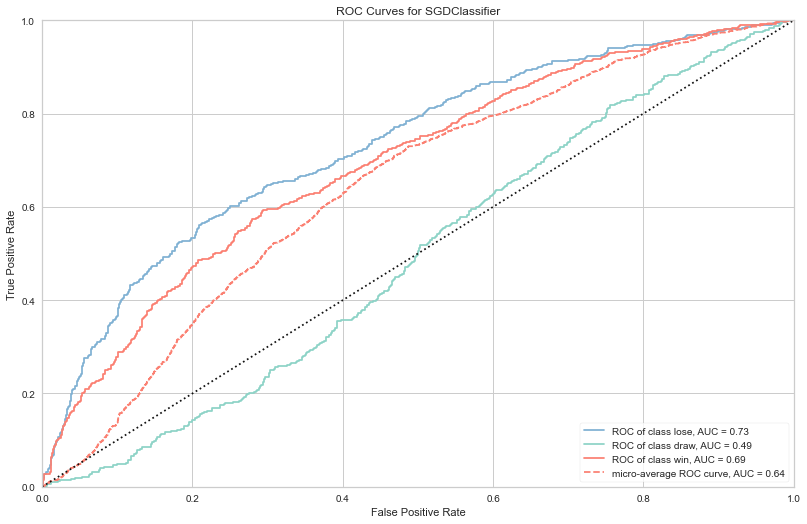

In [11]:
_, base_auc = roc_curve_plot(base,X_train,y_train,X_test,y_test)
auc_micro = np.append(auc_micro,base_auc)
auc_model = np.append(auc_model,'Baseline')

#### Naive Bayes

In [12]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_preds = gnb.predict(X_test) 
gnb_error = error_rate(y_test,y_preds)

print(f'Training error: {error_rate(y_train,gnb.predict(X_train))}')
print(f'Testing error: {gnb_error}')

Training error: 0.5251644736842105
Testing error: 0.48736842105263156


In [13]:
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

          -1       0.46      0.65      0.54       614
           0       0.27      0.12      0.16       429
           1       0.62      0.61      0.61       857

    accuracy                           0.51      1900
   macro avg       0.45      0.46      0.44      1900
weighted avg       0.49      0.51      0.49      1900



In [14]:
confusion_matrix_customize(y_test,y_preds)

,Predict Lose,Predict Draw,Predict Win
Actual Lose,401,67,146
Actual Draw,200,51,178
Actual Win,262,73,522


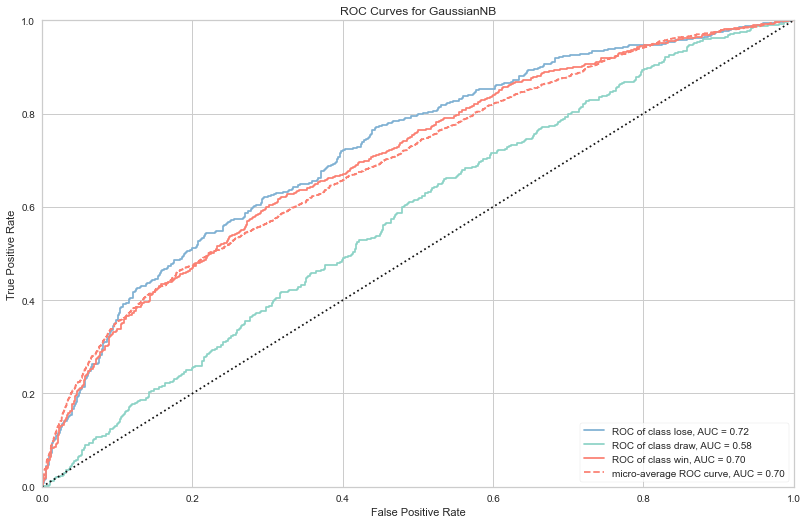

In [15]:
_, gnb_auc = roc_curve_plot(gnb,X_train,y_train,X_test,y_test)
auc_micro = np.append(auc_micro,gnb_auc)
auc_model = np.append(auc_model,'Naive Bayes')

#### Support Vector Machines

In [16]:
from sklearn.svm import SVC

svc = SVC(random_state=3107)
svc.fit(X_train, y_train)
y_preds = svc.predict(X_test) 
svc_error = error_rate(y_test,y_preds)

print(f'Training error: {error_rate(y_train,svc.predict(X_train))}')
print(f'Testing error: {svc_error}')

Training error: 0.48026315789473684
Testing error: 0.4705263157894737


In [17]:
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

          -1       0.56      0.41      0.48       614
           0       0.00      0.00      0.00       429
           1       0.52      0.88      0.65       857

    accuracy                           0.53      1900
   macro avg       0.36      0.43      0.38      1900
weighted avg       0.42      0.53      0.45      1900



In [18]:
confusion_matrix_customize(y_test,y_preds)

,Predict Lose,Predict Draw,Predict Win
Actual Lose,254,0,360
Actual Draw,92,0,337
Actual Win,105,0,752


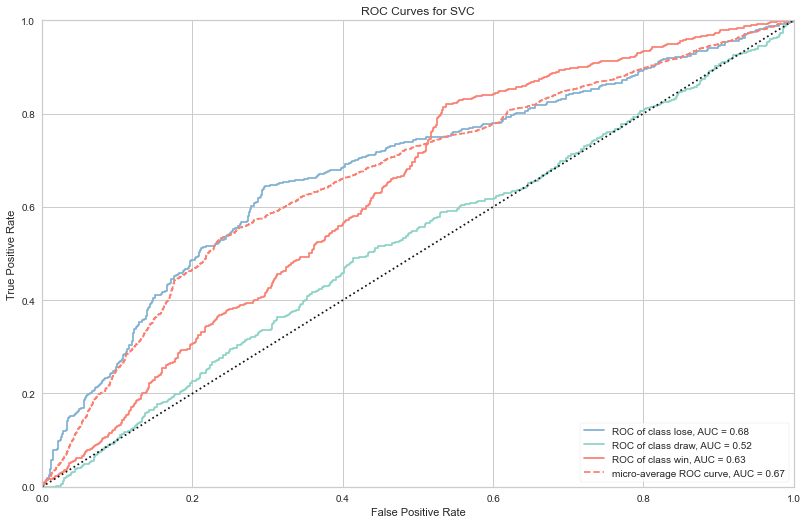

In [19]:
_, svc_auc = roc_curve_plot(svc,X_train,y_train,X_test,y_test)
auc_micro = np.append(auc_micro,svc_auc)
auc_model = np.append(auc_model,'SVM')

#### Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=3107)
rf.fit(X_train, y_train)
y_preds = rf.predict(X_test) 
rf_error = error_rate(y_test,y_preds)

print(f'Training error: {error_rate(y_train,rf.predict(X_train))}')
print(f'Testing error: {rf_error}')

Training error: 0.0
Testing error: 0.48526315789473684


In [21]:
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

          -1       0.54      0.46      0.49       614
           0       0.26      0.12      0.16       429
           1       0.55      0.75      0.63       857

    accuracy                           0.51      1900
   macro avg       0.45      0.44      0.43      1900
weighted avg       0.48      0.51      0.48      1900



In [22]:
confusion_matrix_customize(y_test,y_preds)

,Predict Lose,Predict Draw,Predict Win
Actual Lose,281,62,271
Actual Draw,112,50,267
Actual Win,129,81,647


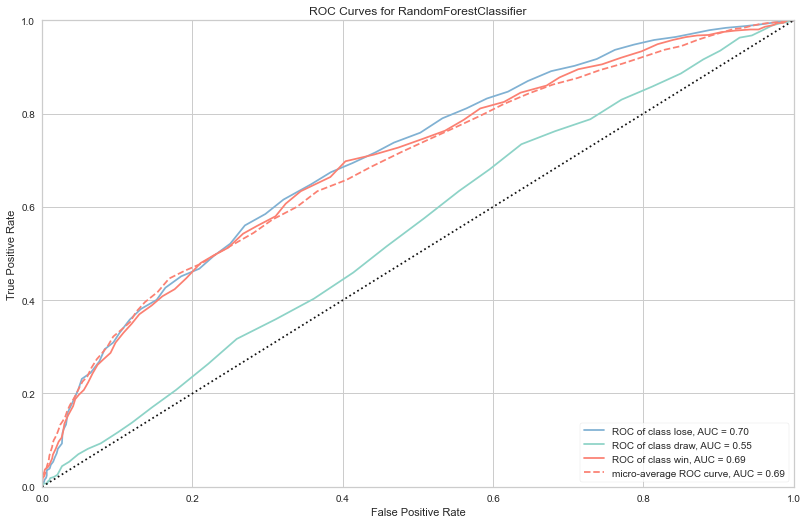

In [23]:
_, rf_auc = roc_curve_plot(rf,X_train,y_train,X_test,y_test)
auc_micro = np.append(auc_micro,rf_auc)
auc_model = np.append(auc_model,'Random Forest')

#### XGBoost

In [24]:
from xgboost import XGBClassifier

xgb = XGBClassifier(eval_metric='mlogloss',random_state=3107)
xgb.fit(X_train, y_train)
y_preds = xgb.predict(X_test) 
xgb_error = error_rate(y_test,y_preds)

print(f'Training error: {error_rate(y_train,xgb.predict(X_train))}')
print(f'Testing error: {xgb_error}')

Training error: 0.025822368421052677
Testing error: 0.5305263157894737


In [25]:
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

          -1       0.48      0.41      0.44       614
           0       0.25      0.16      0.20       429
           1       0.52      0.67      0.59       857

    accuracy                           0.47      1900
   macro avg       0.42      0.41      0.41      1900
weighted avg       0.45      0.47      0.45      1900



In [26]:
confusion_matrix_customize(y_test,y_preds)

,Predict Lose,Predict Draw,Predict Win
Actual Lose,250,91,273
Actual Draw,110,70,249
Actual Win,166,119,572


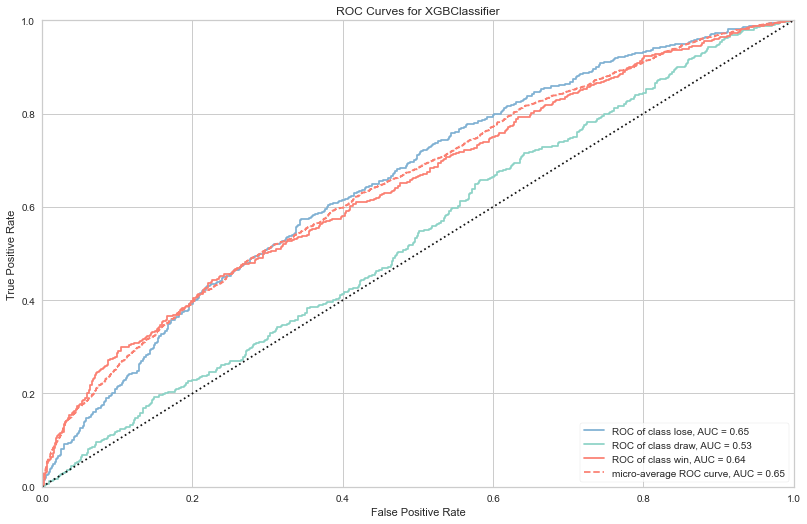

In [27]:
_, xgb_auc = roc_curve_plot(xgb,X_train,y_train,X_test,y_test)
auc_micro = np.append(auc_micro,xgb_auc)
auc_model = np.append(auc_model,'XGBoost')

#### LightGBM

In [28]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(random_state=3107)
lgbm.fit(X_train,y_train)
y_preds = lgbm.predict(X_test)
lgbm_error = error_rate(y_test,y_preds)

print(f'Training error: {error_rate(y_train,lgbm.predict(X_train))}')
print(f'Testing error: {lgbm_error}')

Training error: 0.1506578947368421
Testing error: 0.5042105263157894


In [29]:
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

          -1       0.48      0.43      0.45       614
           0       0.24      0.13      0.16       429
           1       0.56      0.73      0.63       857

    accuracy                           0.50      1900
   macro avg       0.42      0.43      0.42      1900
weighted avg       0.46      0.50      0.47      1900



In [30]:
confusion_matrix_customize(y_test,y_preds)

,Predict Lose,Predict Draw,Predict Win
Actual Lose,261,101,252
Actual Draw,129,54,246
Actual Win,157,73,627


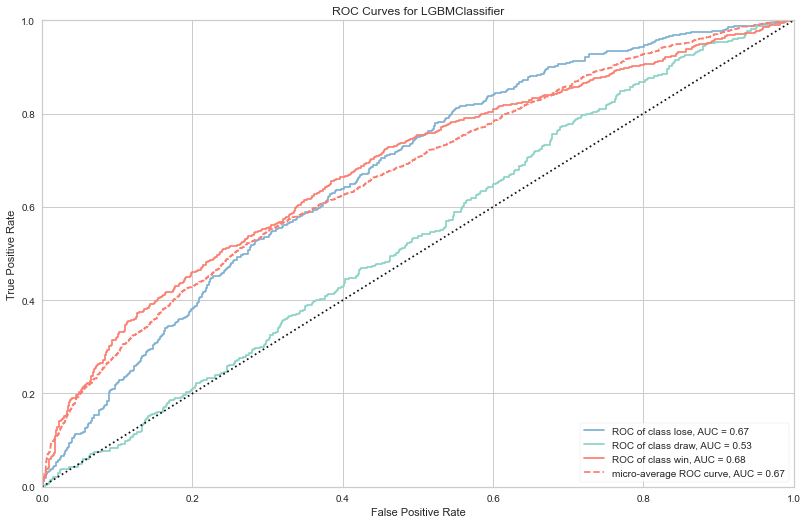

In [31]:
_, lgbm_auc = roc_curve_plot(lgbm,X_train,y_train,X_test,y_test)
auc_micro = np.append(auc_micro,lgbm_auc)
auc_model = np.append(auc_model,'LightGBM')

### Summarize

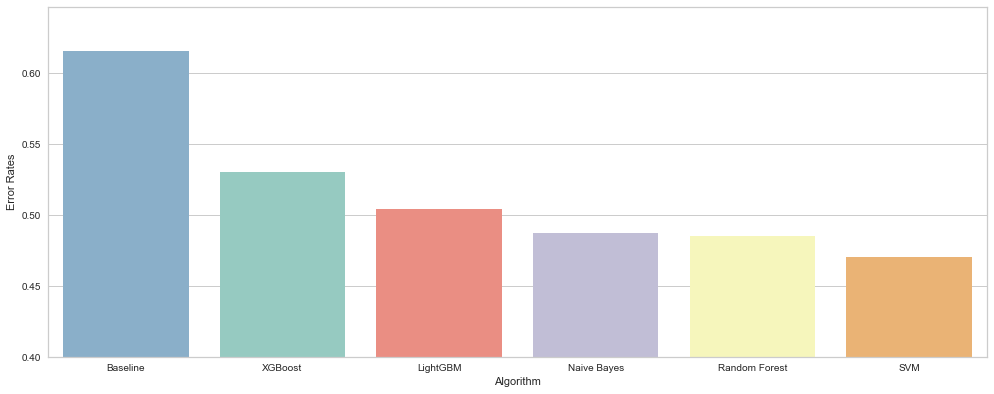

In [32]:
plt.figure(figsize=(15,6))
sns.barplot(x=['Baseline','XGBoost','LightGBM','Naive Bayes','Random Forest','SVM'],y=[base_error,xgb_error,lgbm_error,gnb_error,rf_error,svc_error])
plt.ylabel('Error Rates')
plt.xlabel('Algorithm')
plt.ylim(0.4,)
plt.show()

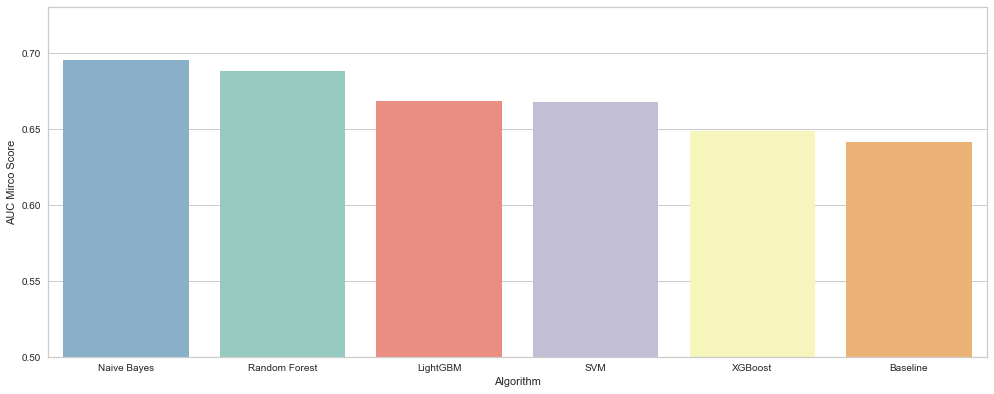

In [33]:
sorted_auc_micro = np.sort(auc_micro)[::-1]
auc_index = np.argsort(auc_micro)[::-1]
sorted_auc_model = np.take(auc_model,auc_index)

plt.figure(figsize=(15,6))
sns.barplot(x=sorted_auc_model,y=sorted_auc_micro)
plt.ylabel('AUC Mirco Score')
plt.xlabel('Algorithm')
plt.ylim(0.5,)
plt.show()

### Model Improvement

#### LightGBM Tuning

In [34]:
from sklearn.model_selection import RandomizedSearchCV

In [35]:
#Max number of bins that feature values will be bucketed in
max_bin = [300,400,500]
#Shrinkage rate
learning_rate = [0.001,0.005,0.01,0.05]
#Number of iterations
num_iterations = [200,500,700,1000,1500,2000]
#Max number of leaves in one tree
num_leaves = [30,50,70,100]
#Boosting type
boosting_type = ['gbdt','dart']
# Create the random grid
random_grid = {'max_bin': max_bin,
               'learning_rate': learning_rate,
               'num_iterations': num_iterations,
               'num_leaves': num_leaves,
               'boosting_type': boosting_type
               }
print(random_grid)

{'max_bin': [300, 400, 500], 'learning_rate': [0.001, 0.005, 0.01, 0.05], 'num_iterations': [200, 500, 700, 1000, 1500, 2000], 'num_leaves': [30, 50, 70, 100], 'boosting_type': ['gbdt', 'dart']}


- Don't run next two cells

In [36]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
lgbm = LGBMClassifier(random_state=3107)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
lgbm_random = RandomizedSearchCV(estimator = lgbm, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=3107, n_jobs = -1,scoring='balanced_accuracy')
# Fit the random search model 
lgbm_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=LGBMClassifier(random_state=3107),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'boosting_type': ['gbdt', 'dart'],
                                        'learning_rate': [0.001, 0.005, 0.01,
                                                          0.05],
                                        'max_bin': [300, 400, 500],
                                        'num_iterations': [200, 500, 700, 1000,
                                                           1500, 2000],
                                        'num_leaves': [30, 50, 70, 100]},
                   random_state=3107, scoring='balanced_accuracy', verbose=2)

In [37]:
lgbm_random.best_params_

{'num_leaves': 30,
 'num_iterations': 1000,
 'max_bin': 400,
 'learning_rate': 0.005,
 'boosting_type': 'gbdt'}

In [38]:
lgbm_tuned = LGBMClassifier(random_state=3107,num_leaves=30,num_iterations=1000,max_bin=400,learning_rate=0.005,boosting_type='gbdt')
lgbm_tuned.fit(X_train,y_train)
y_preds_lgbm = lgbm_tuned.predict(X_test)
lgbm_tuned_error = error_rate(y_test,y_preds_lgbm)

print(f'Training error: {error_rate(y_train,lgbm_tuned.predict(X_train))}')
print(f'Testing error: {lgbm_tuned_error}')

Training error: 0.2952302631578947
Testing error: 0.4826315789473684


In [39]:
print(classification_report(y_test,y_preds_lgbm))

              precision    recall  f1-score   support

          -1       0.52      0.48      0.50       614
           0       0.25      0.09      0.13       429
           1       0.55      0.76      0.64       857

    accuracy                           0.52      1900
   macro avg       0.44      0.44      0.42      1900
weighted avg       0.47      0.52      0.48      1900



In [40]:
confusion_matrix_customize(y_test,y_preds_lgbm)

,Predict Lose,Predict Draw,Predict Win
Actual Lose,294,58,262
Actual Draw,126,37,266
Actual Win,149,56,652


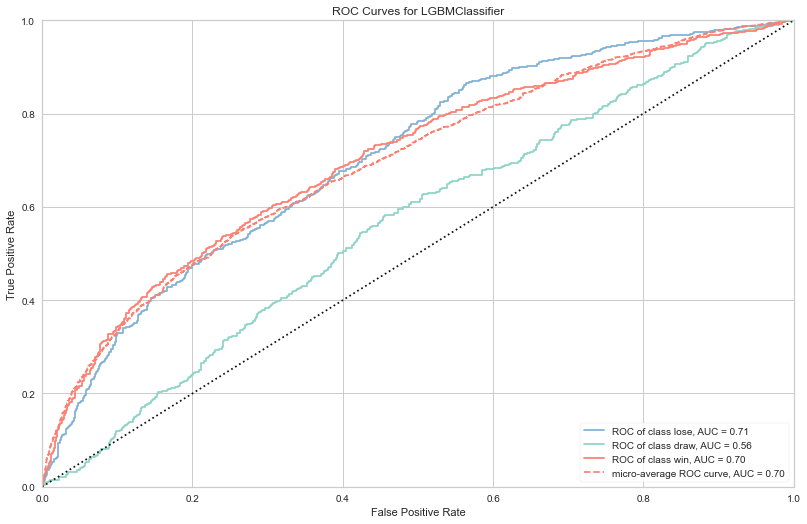

In [41]:
_, lgbm_auc = roc_curve_plot(lgbm_tuned,X_train,y_train,X_test,y_test)

#### Random Forest Tuning

In [42]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


- Don't run next two cells

In [43]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state=3107)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=3107, n_jobs = -1,scoring='balanced_accuracy')
# Fit the random search model 
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=3107),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=3107, scoring='balanced_accuracy', verbose=2)

In [44]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 60,
 'bootstrap': True}

In [45]:
rf_tuned = RandomForestClassifier(random_state=3107,n_estimators=200,min_samples_split=10,min_samples_leaf=2,max_features='sqrt',max_depth=60,bootstrap=True)
rf_tuned.fit(X_train,y_train)
y_preds_rf = rf_tuned.predict(X_test)
rf_tuned_error = error_rate(y_test,y_preds_rf)

print(f'Training error: {error_rate(y_train,rf_tuned.predict(X_train))}')
print(f'Testing error: {rf_tuned_error}')

Training error: 0.06299342105263162
Testing error: 0.47526315789473683


In [46]:
print(classification_report(y_test,y_preds_rf))

              precision    recall  f1-score   support

          -1       0.53      0.47      0.50       614
           0       0.26      0.08      0.12       429
           1       0.55      0.79      0.65       857

    accuracy                           0.52      1900
   macro avg       0.45      0.45      0.42      1900
weighted avg       0.48      0.52      0.48      1900



In [47]:
confusion_matrix_customize(y_test,y_preds_rf)

,Predict Lose,Predict Draw,Predict Win
Actual Lose,291,53,270
Actual Draw,110,33,286
Actual Win,144,40,673


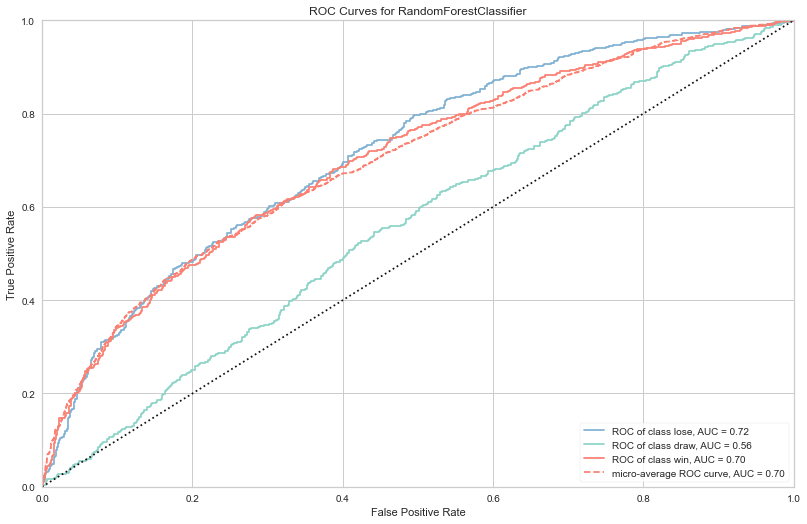

In [48]:
_, rf_auc = roc_curve_plot(rf_tuned,X_train,y_train,X_test,y_test)

#### Naive Bayes Tuning

In [49]:
# Create the random grid
random_grid = {'var_smoothing': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]}
print(random_grid)

{'var_smoothing': [0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07, 1e-08, 1e-09, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]}


In [50]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
gnb = GaussianNB()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gnb_random = RandomizedSearchCV(estimator = gnb, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=3107, n_jobs = -1,scoring='balanced_accuracy')
# Fit the random search model 
gnb_random.fit(X_train, y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


RandomizedSearchCV(cv=3, estimator=GaussianNB(), n_iter=20, n_jobs=-1,
                   param_distributions={'var_smoothing': [0.01, 0.001, 0.0001,
                                                          1e-05, 1e-06, 1e-07,
                                                          1e-08, 1e-09, 1e-10,
                                                          1e-11, 1e-12, 1e-13,
                                                          1e-14, 1e-15]},
                   random_state=3107, scoring='balanced_accuracy', verbose=2)

In [51]:
gnb_random.best_params_

{'var_smoothing': 0.0001}

In [52]:
gnb_tuned = GaussianNB(var_smoothing=0.0001)
gnb_tuned.fit(X_train, y_train)
y_preds_gnb = gnb_tuned.predict(X_test) 
gnb_tuned_error = error_rate(y_test,y_preds_gnb)

print(f'Training error: {error_rate(y_train,gnb_tuned.predict(X_train))}')
print(f'Testing error: {gnb_tuned_error}')

Training error: 0.5194078947368421
Testing error: 0.4742105263157895


In [53]:
print(classification_report(y_test,y_preds_gnb))

              precision    recall  f1-score   support

          -1       0.48      0.65      0.56       614
           0       0.29      0.10      0.15       429
           1       0.60      0.65      0.62       857

    accuracy                           0.53      1900
   macro avg       0.46      0.47      0.44      1900
weighted avg       0.49      0.53      0.50      1900



In [54]:
confusion_matrix_customize(y_test,y_preds_gnb)

,Predict Lose,Predict Draw,Predict Win
Actual Lose,399,47,168
Actual Draw,183,44,202
Actual Win,241,60,556


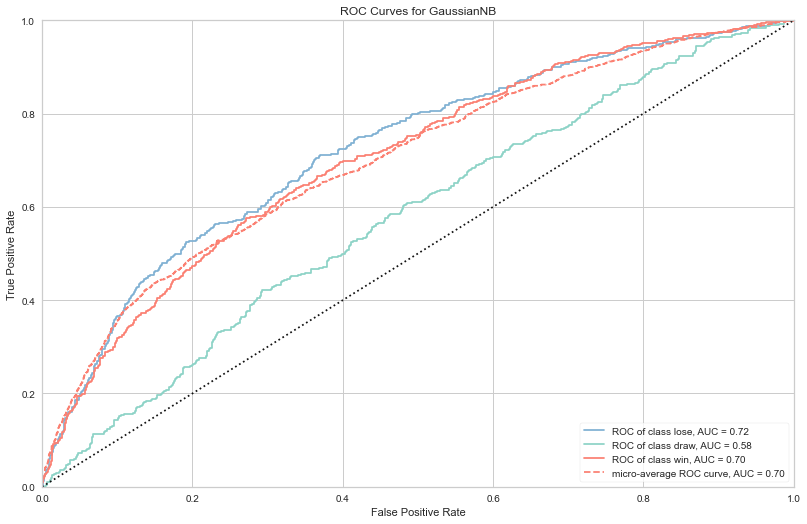

In [55]:
_, gnb_auc = roc_curve_plot(gnb_tuned,X_train,y_train,X_test,y_test)

## Future Work

### Oversampling data

In [64]:
# from imblearn.over_sampling import SMOTE
# from collections import Counter
# from sklearn.preprocessing import LabelEncoder
# # split into input and output elements
# X, y = train_df.drop(['Outcome'],axis=1), train_df['Outcome']
# # transform the dataset
# strategy = {0:3000,1:3000,2:4000}
# oversample = SMOTE(sampling_strategy=strategy)
# X, y = oversample.fit_resample(X, y)

# train_df = pd.merge(X,y,left_index=True,right_index=True)
# train_df